# Load libraries and data

In [1]:
!pip install whit-phys-util

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import whit_phys_util as buc
from string import ascii_uppercase
import scipy.constants as sciConst

# Connect to GitHub

In [3]:
repo = buc.local_repository("https://github.com/PS251-FA21/leds-and-plancks-constant-gmcdonald24")

Repository exists at this location. Pulling changes from GitHub.


# Equipment
|Description | Manufacturer | Model | ID # or SN|
|------- | ------- | ------- | -------|
Spectrometer | Ocean Optics | USB4000 | USB4F07107
Power supply | BK precision | 9172 | 367C13104

* Collection of LEDs
* 100 $\Omega$ resistor
* cables
* breadboard
* hookup wire



# Procedure 
1. Connect first LED and resistor to the power supply in series
2. Turn on power supply to 5V
3. use Ocean Optics softare and spectrometer to measure the peak wavelength of the LED
4. repeat process for the remaining LEDs

# Analysis

In [4]:
leds = list(ascii_uppercase[0:3]+ascii_uppercase[4:12])
print(leds)

['A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


In [5]:
dfc = {} # collection of DataFrames for LED I-V data
for led in leds:
  dfc[led] = pd.read_csv(f'LED-{led}-current-data.csv')

In [6]:
dfc['A'].head()

,Voltage (V),Current (A)
0,0.00,-0.0
1,0.01,-0.0
2,0.02,-0.0
3,0.03,-0.0
4,0.04,-0.0


In [7]:
wavelengths = pd.read_table('LED wavelengths.tsv', index_col=0)
wavelengths
wavelengths.drop('D',inplace=True)

In [8]:
V_total = {}
I ={}
for led in leds:
  V_total[led]=dfc[led]['Voltage (V)']
  I[led] = dfc[led]['Current (A)']
led_sets = [leds[0:4], leds[4:8], leds[8:12]]
numSets = len(led_sets)

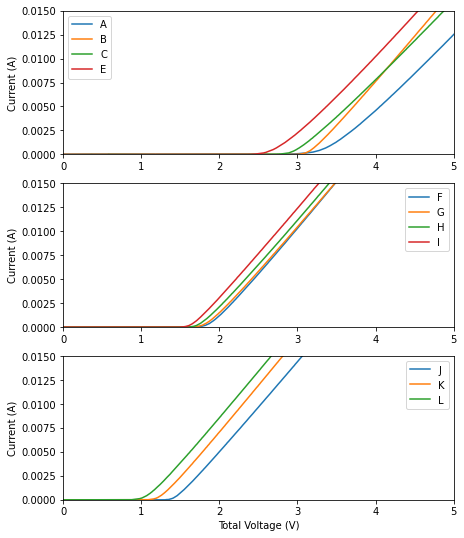

In [9]:
fig1, ax1 = plt.subplots(numSets, 1, figsize = (7,9))
for i in range(numSets):
  for led in led_sets[i]:
    ax1[i].plot(V_total[led], I[led], label=led)
  ax1[i].set_ylabel("Current (A)")
  ax1[i].set_xlim(0,5)
  ax1[i].set_ylim(0,0.015)
  ax1[i].legend()
ax1[numSets-1].set_xlabel("Total Voltage (V)");

In [10]:
V_LED= {}
for led in leds:
  V_LED[led] = V_total[led] - 98.7*I[led]

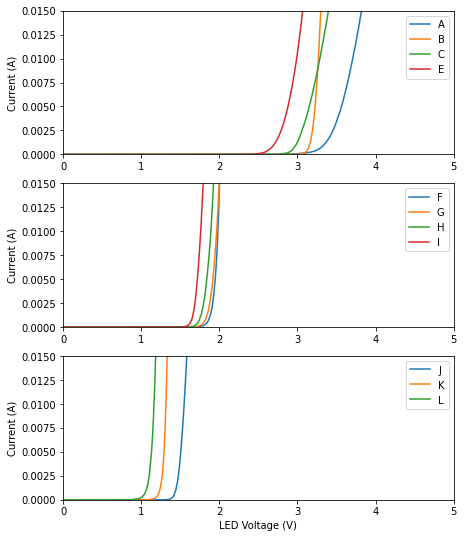

In [11]:
fig2, ax2 = plt.subplots(numSets, 1, figsize = (7,9))
for i in range(numSets):
  for led in led_sets[i]:
    ax2[i].plot(V_LED[led], I[led], label=led)
  ax2[i].set_ylabel("Current (A)")
  ax2[i].set_xlim(0,5)
  ax2[i].set_ylim(0,0.015)
  ax2[i].legend()
ax2[numSets-1].set_xlabel("LED Voltage (V)");

# Prototype locating activation

In [12]:
base_indices = np.where(V_LED['C']<=0.6)[0]
avgBase = I['C'][base_indices].mean()
stdBase = I['C'][base_indices].std()
print(avgBase, stdBase)

8.196721311475414e-06 7.18985320232884e-06


In [13]:
thresh = avgBase + 5*stdBase
print(thresh)

4.4145987323119615e-05


In [14]:
above_thresh_indices = np.where(I['C']>thresh)
first_above_thresh = above_thresh_indices[0][0]
print(first_above_thresh)
V_LED['C'][first_above_thresh]

277


2.765064999999985

# Locating activation voltage for all LEDs

In [15]:
V_on_list = []
for led in leds:
  above_thresh_indices = np.where(I[led] > thresh)
  first_above_thresh = above_thresh_indices[0][0]
  V_on_list.append(V_LED[led][first_above_thresh])
V_on = np.array(V_on_list)
print(V_on)

[2.905065 3.035065 2.765065 2.465065 1.735065 1.705065 1.645065 1.555065
 1.355065 1.125065 0.925065]


# Determining h

In [22]:
wavelengths_inverse = 1/wavelengths['Peak wavelength (nm)']
fitTable, fitFunc = buc.prettyPolyFit(wavelengths_inverse, V_on)
fitTable

,slope,intercept
value,1206.130209,-0.261017
uncertainty,175.994618,0.334911


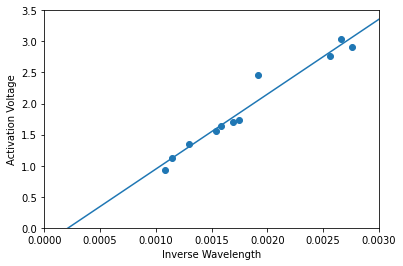

In [23]:
x= np.linspace(0,3.5,100)
fig3, ax3 = plt.subplots()
ax3.scatter(wavelengths_inverse, V_on);
ax3.set_xlabel("Inverse Wavelength");
ax3.set_ylabel("Activation Voltage");
ax3.set_xlim(0,.003);
ax3.set_ylim(0,3.5);
ax3.plot(x, fitFunc(x));

In [24]:
fitTable['slope']['value']

1206.1302085027296

In [25]:
e = sciConst.e
c = sciConst.c
h = (fitTable['slope']['value']*10**-9)*(e/c)
dh = (fitTable['slope']['uncertainty']*10**-9)*(e/c)
print(h, dh)

6.445904778647305e-34 9.405655706879478e-35


In [26]:
percentErr = (h-sciConst.h)/sciConst.h*100
print(percentErr)

-2.719038091570686


In [27]:
print(type(V_on))
print(type(wavelengths))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [29]:
E_thermal = []
for i, led in enumerate(leds):
  E_thermal.append( (e * V_on[i]-sciConst.h*c/(wavelengths['Peak wavelength (nm)'][led]*1e-9))/e )
E_thermal

[-0.5199128572707433,
 -0.26238708598939003,
 -0.4058863665780268,
 0.0944302307227399,
 -0.42493845702439353,
 -0.38926267623648975,
 -0.3198192857876412,
 -0.3553232655346712,
 -0.24887029667788063,
 -0.3000407291172436,
 -0.41241286875081123]

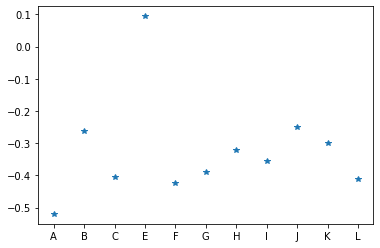

In [30]:
fig4,ax4 = plt.subplots()
ax4.plot(leds,list(E_thermal),"*");